In [14]:
from constants import DatasetPath

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import timm

import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

from skimage import io
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from tqdm.notebook import tqdm
import os

import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [15]:
# Main Dataset folder path
DATA_DIR = DatasetPath.effectivePath

# HYPERPARAMETRES

BATCH_SIZE = 16

LR = 0.001

EPOCHS = 30

# Device to run calculations on 
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
df = pd.read_csv(DATA_DIR + "trainingSet.csv")

train_df, valid_df = train_test_split(df, test_size = 0.20, random_state = 42)
print(len(train_df))
print(len(valid_df))
print(df.shape)

15680
3920
(19600, 3)


In [17]:
# Class to provide useful functions and prepare the data for NN use 
class APN_Dataset(Dataset):
    """
    Uploads images from Dataset and set them up for Neural Network use.

    Parameters
    ----------
        Dataset (pd.DataFrame): the DataFrame containing the dataset.
    """
    
    def __init__(self, df):
        """
        Initializes the class with the DataFrame in input.

        Parameters
        ----------
            df (pd.DataFrame): the DataFrame containing the dataset.
        """
        self.df = df

    def __len__(self):
        """
        Calculates the number of tuples in the dataset.

        Returns
        -------
            (int): number of tuples in the dataset.
        """    
        return len(self.df)

    def __getitem__(self, idx):
        """
        Retrieves the images at the given row index.

        Parameters
        ----------
            idx (int): dataset row index.

        Returns
        -------
            A_img, P_img, N_img (ndarray): the anchor, positive and negative images at row[idx] 
        """
        row = self.df.iloc[idx]

        A_img = io.imread(DATA_DIR + row.anchor)
        P_img = io.imread(DATA_DIR + row.positive)
        N_img = io.imread(DATA_DIR + row.negative)

        #Permute because the third channel has to be in first channel in torch

        #A_img = torch.from_numpy(A_img).permute(2, 0, 1) / 255.0
        #P_img = torch.from_numpy(P_img).permute(2, 0, 1) / 255.0
        #N_img = torch.from_numpy(N_img).permute(2, 0, 1) / 255.0


        A_img = np.expand_dims(A_img, 0)
        P_img = np.expand_dims(P_img, 0)
        N_img = np.expand_dims(N_img, 0)

        A_img = torch.from_numpy(A_img) / 255.0
        P_img = torch.from_numpy(P_img) / 255.0
        N_img = torch.from_numpy(N_img) / 255.0

        #A_img = torch.from_numpy(A_img.astype(np.int32)) / 65536.0
        #P_img = torch.from_numpy(P_img.astype(np.int32)) / 65536.0
        #N_img = torch.from_numpy(N_img.astype(np.int32)) / 65536.0

        return A_img, P_img, N_img

In [18]:
# APN_Dataset objects creation

trainset = APN_Dataset(train_df)
validset = APN_Dataset(valid_df)

print(f"Size of trainset: {len(trainset)}")
print(f"Size of validset: {len(validset)}")

Size of trainset: 15680
Size of validset: 3920


In [19]:
# DataLoader creation to handle loading data into memory

trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 980
No. of batches in validloader : 245


In [20]:
class APN_Model(nn.Module):
    """
    Defines a neural network model class APN_Model that uses an EfficientNet (specifically the B0 version) as its backbone.
    """

    def __init__(self, emb_size = 512):
        """
        Initializes the APN_Model with a specific model and a classifier that outputs embedding vector of the specified size.

        Parameters
        ----------
        emb_size (int, optional): the size of the output embedding vector (default is 512).
        """
        super(APN_Model, self).__init__()

        # Define the model to use 
        self.efficientnet = timm.create_model('tf_efficientnetv2_b0', pretrained = False)
        
        # Replace the classifier layer with a linear layer that outputs embeddings of size `emb_size`
        self.efficientnet.classifier = nn.Linear(in_features=self.efficientnet.classifier.in_features, out_features = emb_size)

    def forward(self, images):
        """
        Performs the forward pass of the model, which takes a batch of images and returns their embeddings.

        Parameters
        ----------
            images (torch.Tensor): a batch of images to process.

        Returns
        -------
            embeddings (torch.Tensor): a batch of embeddings of size `emb_size`.
        """
        embeddings = self.efficientnet(images)
        return embeddings

In [21]:
# NN mod to accept greyscale fourier spectrum images instead of RGB

model = APN_Model()
model.efficientnet.conv_stem = nn.Conv2d(1, 32, 3, 2, 1, bias=False)

model.to(DEVICE)

APN_Model(
  (efficientnet): EfficientNet(
    (conv_stem): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): ConvBnAct(
          (conv): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNormAct2d(
            16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (drop_path): Identity()
        )
      )
      (1): Sequential(
        (0): EdgeResidual(
          (conv_exp): Conv2dSame(16, 64, kernel_size=(3, 3), stride=(2, 2), bias=False)
          (bn1): BatchNormAct2d(
            64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
     

In [22]:
def train_fn(model, dataloader, optimizer, criterion):
    """
    Trains the model for one epoch using the provided dataloader, optimizer, and criterion.

    Parameters
    ----------
        model (torch.nn.Module): the neural network model to be trained.
        dataloader (torch.utils.data.DataLoader): the dataloader providing batches of anchor, positive, and negative image triplets.
        optimizer (torch.optim.Optimizer): the optimizer used to update the model's parameters.
        criterion (function): the loss function used to compute the loss between the model's outputs.

    Returns
    -------
        (float) : the average training loss over all batches.
    """

    # Sets the model to training mode
    model.train() #ON Dropout
    total_loss = 0.0

    # Iterates over the batches of data provided by the dataloader.
    # Each batch consists of triplets: anchor (A), positive (P), and negative (N) images.
    for A, P, N in tqdm(dataloader):
        # Moves the anchor, positive, and negative images to the specified device.
        A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

        # Passes the anchor, positive, and negative images through the model to obtain their embeddings.
        A_embs = model(A)
        P_embs = model(P)
        N_embs = model(N)

        # Computes the loss using the specified loss function
        loss = criterion(A_embs, P_embs, N_embs)

        # Clears the gradients of all optimized parameters.
        # Important to prevent accumulation of gradients from multiple forward passes.
        optimizer.zero_grad()

        # Computes the gradient of the loss with respect to the model's parameters (backpropagation).
        loss.backward()
        
        # Updates the model's parameters based on the computed gradients.
        optimizer.step()

        # Updates toal loss at the end of each iteration
        total_loss += loss.item()

    return total_loss / len(dataloader)

In [23]:
def eval_fn(model, dataloader, criterion):
    """
    Evaluates the model using the provided dataloader and criterion.

    Parameters
    ----------
        model (torch.nn.Module): the neural network model to be evaluated.
        dataloader (torch.utils.data.DataLoader): the dataloader providing batches of anchor, positive, and negative image triplets.
        criterion (function): the loss function used to compute the loss between the model's outputs.

    Returns
    -------
        (float): the average validation loss over all batches.
    """
    
    # Sets the model to evaluation mode
    model.eval() #OFF Dropout
    total_loss = 0.0

    # Disables gradient calculation.
    # Important to reduce memory usage and speed up computations since gradients are not needed.
    with torch.no_grad():
        # Iterates over the batches of data provided by the dataloader.
        for A, P, N in tqdm(dataloader):
             # Moves the anchor, positive, and negative images to the specified device.
            A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

            # Passes the anchor, positive, and negative images through the model to obtain their embeddings.
            A_embs = model(A)
            P_embs = model(P)
            N_embs = model(N)

            # Computes the loss using the specified loss function
            loss = criterion(A_embs, P_embs, N_embs)

            # Updates toal loss at the end of each iteration
            total_loss += loss.item()

    return total_loss / len(dataloader)

In [24]:
# Definition of the loss function and the optimizer to utilize.

criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

# Learning Rate Scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=7)

In [25]:
model_path = DATA_DIR + 'best_model.pt'
loss_path =  DATA_DIR + 'best_valid_loss.txt'

def save_checkpoint(best_valid_loss):
    """
    Saves best model along with its valid loss to a '.txt' file

    Parametres
    ----------
        best_valid_loss (float): the best valid loss calculated among all training sessions.
    """
    torch.save(model.state_dict(), model_path)
    with open(loss_path, 'w') as f:
        f.write(str(best_valid_loss))

    print("CHECKPOINT_SAVED")

def load_checkpoint():
    """
    Loads the best model and its valid loss from a '.txt' file. In case one of these can't be found, the training starts from scratch

    Returns
    -------
        best_valid_loss (float, np.Inf): if the best valid loss exists, returns a float; else returns an Infinite value
    """
    if os.path.exists(model_path) and os.path.exists(loss_path):
        print("CHECKPOINT_LOADED")
        model.load_state_dict(torch.load(model_path))
        with open(loss_path, 'r') as f:
            best_valid_loss = float(f.read())
            return best_valid_loss

    print("UNABLE_TO_LOAD_CHECKPOINT")
    return np.Inf

In [26]:
# Loads the best validation loss from a previously saved checkpoint.
# (This allows the training process to resume from the best state observed so far)
best_valid_loss = load_checkpoint()

# Lists to store train_loss and valid_loss values
train_losses = []
valid_losses = []

# Loops over the specified number of epochs.
for i in range(EPOCHS):

    torch.cuda.empty_cache()

    # Trains and evaluates the model
    train_loss = train_fn(model, trainloader, optimizer, criterion)
    valid_loss = eval_fn(model, validloader, criterion)

    # LR Scheduler updates 
    scheduler.step(valid_loss)

    # If the validation loss has improved, it saves the current state of the model and updates the best valid loss
    if valid_loss < best_valid_loss:
        save_checkpoint(valid_loss)
        best_valid_loss = valid_loss

    # Save train_loss and valid_loss values
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    # Prints the stats relative to the current epoch.
    print(f"EPOCHS : {i+1} train_loss : {train_loss} valid_loss : {valid_loss} Learning Rate: {scheduler.get_last_lr()}")

UNABLE_TO_LOAD_CHECKPOINT


  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/245 [00:00<?, ?it/s]

CHECKPOINT_SAVED
EPOCHS : 1 train_loss : 0.8941697188177887 valid_loss : 0.8130162792546408 Learning Rate: [0.001]


  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/245 [00:00<?, ?it/s]

EPOCHS : 2 train_loss : 0.7948765433260373 valid_loss : 0.8215331211382029 Learning Rate: [0.001]


  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/245 [00:00<?, ?it/s]

CHECKPOINT_SAVED
EPOCHS : 3 train_loss : 0.8205893921000617 valid_loss : 0.7900013416397328 Learning Rate: [0.001]


  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/245 [00:00<?, ?it/s]

CHECKPOINT_SAVED
EPOCHS : 4 train_loss : 0.7850664111348439 valid_loss : 0.7664310761860439 Learning Rate: [0.001]


  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/245 [00:00<?, ?it/s]

EPOCHS : 5 train_loss : 0.8174778943615301 valid_loss : 0.8306448926731032 Learning Rate: [0.001]


  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/245 [00:00<?, ?it/s]

CHECKPOINT_SAVED
EPOCHS : 6 train_loss : 0.7564706532854815 valid_loss : 0.7508944383689335 Learning Rate: [0.001]


  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/245 [00:00<?, ?it/s]

EPOCHS : 7 train_loss : 0.7516154304146767 valid_loss : 0.7554013669490814 Learning Rate: [0.001]


  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/245 [00:00<?, ?it/s]

CHECKPOINT_SAVED
EPOCHS : 8 train_loss : 0.741396918778821 valid_loss : 0.7190029062786881 Learning Rate: [0.001]


  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/245 [00:00<?, ?it/s]

CHECKPOINT_SAVED
EPOCHS : 9 train_loss : 0.7683836904335387 valid_loss : 0.7101588409774158 Learning Rate: [0.001]


  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/245 [00:00<?, ?it/s]

EPOCHS : 10 train_loss : 0.7314126710198363 valid_loss : 0.7698701826893554 Learning Rate: [0.001]


  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/245 [00:00<?, ?it/s]

EPOCHS : 11 train_loss : 0.7264846725655454 valid_loss : 0.7910872837718652 Learning Rate: [0.001]


  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/245 [00:00<?, ?it/s]

EPOCHS : 12 train_loss : 0.7233773313386708 valid_loss : 0.7246787866767572 Learning Rate: [0.001]


  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/245 [00:00<?, ?it/s]

EPOCHS : 13 train_loss : 0.6943845207745931 valid_loss : 0.7219978681632451 Learning Rate: [0.001]


  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/245 [00:00<?, ?it/s]

CHECKPOINT_SAVED
EPOCHS : 14 train_loss : 0.7171708559579387 valid_loss : 0.7089977455382445 Learning Rate: [0.001]


  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/245 [00:00<?, ?it/s]

EPOCHS : 15 train_loss : 0.6876286165522677 valid_loss : 0.711894351365615 Learning Rate: [0.001]


  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/245 [00:00<?, ?it/s]

EPOCHS : 16 train_loss : 0.6716661708695548 valid_loss : 0.7858061729645243 Learning Rate: [0.001]


  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/245 [00:00<?, ?it/s]

EPOCHS : 17 train_loss : 0.6468552487845324 valid_loss : 0.7406975973625572 Learning Rate: [0.001]


  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/245 [00:00<?, ?it/s]

CHECKPOINT_SAVED
EPOCHS : 18 train_loss : 0.6255250907598101 valid_loss : 0.6719435021585348 Learning Rate: [0.001]


  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/245 [00:00<?, ?it/s]

EPOCHS : 19 train_loss : 0.629358081223101 valid_loss : 0.6784113132223791 Learning Rate: [0.001]


  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/245 [00:00<?, ?it/s]

EPOCHS : 20 train_loss : 0.7144472199815268 valid_loss : 0.7733873259048073 Learning Rate: [0.001]


  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/245 [00:00<?, ?it/s]

EPOCHS : 21 train_loss : 0.656857428882195 valid_loss : 0.7175572960960622 Learning Rate: [0.001]


  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/245 [00:00<?, ?it/s]

CHECKPOINT_SAVED
EPOCHS : 22 train_loss : 0.6121029907571418 valid_loss : 0.6708027728966304 Learning Rate: [0.001]


  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/245 [00:00<?, ?it/s]

EPOCHS : 23 train_loss : 0.6022839624966894 valid_loss : 0.7042680633311369 Learning Rate: [0.001]


  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/245 [00:00<?, ?it/s]

CHECKPOINT_SAVED
EPOCHS : 24 train_loss : 0.5809345459603533 valid_loss : 0.6545420327965095 Learning Rate: [0.001]


  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/245 [00:00<?, ?it/s]

EPOCHS : 25 train_loss : 0.580055591000282 valid_loss : 0.6603620356138872 Learning Rate: [0.001]


  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/245 [00:00<?, ?it/s]

CHECKPOINT_SAVED
EPOCHS : 26 train_loss : 0.5669519168001657 valid_loss : 0.6142915431942259 Learning Rate: [0.001]


  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/245 [00:00<?, ?it/s]

EPOCHS : 27 train_loss : 0.5568117720512104 valid_loss : 0.6193323905370673 Learning Rate: [0.001]


  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/245 [00:00<?, ?it/s]

CHECKPOINT_SAVED
EPOCHS : 28 train_loss : 0.5172698174964409 valid_loss : 0.6131201791520021 Learning Rate: [0.001]


  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/245 [00:00<?, ?it/s]

CHECKPOINT_SAVED
EPOCHS : 29 train_loss : 0.5138887950732391 valid_loss : 0.5966005041283005 Learning Rate: [0.001]


  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/245 [00:00<?, ?it/s]

EPOCHS : 30 train_loss : 0.4987777345946857 valid_loss : 0.6083383084559927 Learning Rate: [0.001]


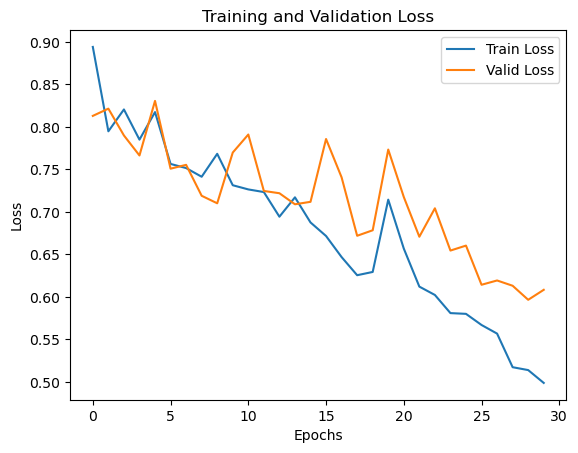

In [27]:
# Plot train_loss and valid_loss
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [28]:
#QUESTA E' LA FUNZIONE PER GENERARE I VETTORI DI ENCODING
def get_encoding_csv(model, anc_img_names, dirFolder):
    """
    Generates encoding vectors for a set of input images using a provided model and returns a DataFrame
    with image names and their corresponding encodings.

    Parameters
    ----------
        model (torch.nn.Module): the neural network model used to generate embeddings.
        anc_img_names (list or numpy.ndarray): filenames (or paths) of the anchor images.
        dirFolder (str): the directory path where the anchor images are located.

    Returns
    -------
        df_enc (pandas.DataFrame): a DataFrame containing the anchor image names and their corresponding encodings.
    """
    # Convert the list of anchor image names to a NumPy array
    anc_img_names_arr = np.array(anc_img_names)

    encodings = []

    # Set the model to evaluation mode
    model.eval()

    with torch.no_grad():
        for i in tqdm(anc_img_names_arr):
            # Read the image from the specified directory
            A = io.imread(dirFolder + i)
            # Add a batch dimension to the image
            A = np.expand_dims(A, 0)
            # Convert the image to a PyTorch tensor and normalize to the range [0, 1]
            A = torch.from_numpy(A.astype(np.int32)) / 255.0
            #A = torch.from_numpy(A).permute(2, 0, 1) / 255.0 #FOR RGB IMAGES
            
            A = A.to(DEVICE)
            # Pass the preprocessed image through the model to obtain its embedding
            A_enc = model(A.unsqueeze(0))
             # Append the embedding to the list (move to CPU and convert to NumPy array)
            encodings.append(A_enc.squeeze().cpu().detach().numpy())

        # Convert the list of embeddings to a NumPy array
        encodings = np.array(encodings)
        # Create a DataFrame with the embeddings
        encodings = pd.DataFrame(encodings)
        # Concatenate the anchor image names with their corresponding embeddings
        df_enc = pd.concat([anc_img_names, encodings], axis = 1)

        return df_enc

In [30]:
# Load the best model found during training
model.load_state_dict(torch.load('best_model.pt'))

# Call 'get_encoding_csv' on the dataset to generate the DataFrame containing anchors and their encoding vector
df_enc = get_encoding_csv(model, df['anchor'], DATA_DIR)

# Save the encodings database to avoid redoing this process
# (This process has to be redone only when finding a better model)
df_enc.to_csv(DATA_DIR + 'database.csv', index = False)

df_enc = pd.read_csv(DATA_DIR + 'database.csv')
df_enc.head()

  0%|          | 0/19600 [00:00<?, ?it/s]

,anchor,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,fourier\fourier\coco+coco+coco2017+train2017+r...,-0.597154,-0.168612,-1.183906,-0.051745,0.261435,-0.729093,-0.444731,0.232492,0.465439,...,0.697613,-6.392803,0.662623,-2.987497,-0.131759,-1.221228,-0.350030,0.477069,-0.221559,-0.099267
1,fourier\fourier\coco+coco+coco2017+test2017+re...,-0.596127,-0.159986,-1.188494,-0.052813,0.259504,-0.734887,-0.448898,0.233154,0.462471,...,0.700296,-6.454501,0.667453,-2.999353,-0.126168,-1.229809,-0.351312,0.477467,-0.223356,-0.097941
2,fourier\fourier\coco+coco+coco2017+train2017+r...,-0.597491,-0.163454,-1.188486,-0.052378,0.260007,-0.734175,-0.448385,0.233058,0.464270,...,0.700345,-6.446735,0.666926,-2.998958,-0.128706,-1.228530,-0.350826,0.477976,-0.222685,-0.098349
3,fourier\fourier\coco+coco+coco2017+train2017+r...,-0.598142,-0.162025,-1.191338,-0.052640,0.260545,-0.735835,-0.449103,0.233651,0.464277,...,0.701651,-6.464086,0.668626,-3.005973,-0.126940,-1.231555,-0.352124,0.478630,-0.223686,-0.098514
4,fourier\fourier\coco+coco+coco2017+test2017+re...,-0.598114,-0.165505,-1.189091,-0.051764,0.260740,-0.733169,-0.447156,0.232865,0.465251,...,0.700165,-6.439265,0.666267,-2.999958,-0.128944,-1.227615,-0.350994,0.477861,-0.222722,-0.098980


In [31]:
def euclidean_dist(img_enc, anc_enc_arr):
    """
    Computes the Euclidean distance between a given image encoding and an array of anchor encodings.

    Parameters
    ----------
        img_enc (numpy.ndarray): a 1D array representing the encoding of the image.
        anc_enc_arr (numpy.ndarray): a 2D array representing the anchor images and their encodings.

    Returns
    -------
        dist (numpy.ndarray): a 1D array containing the Euclidean distances between the image encoding and each of the anchors' one.
    """
    #dist = np.sqrt(np.dot(img_enc-anc_enc_arr, (img_enc- anc_enc_arr).T))
    dist = np.dot(img_enc-anc_enc_arr, (img_enc- anc_enc_arr).T)
    #dist = np.sqrt(dist)
    
    return dist

In [32]:
test_df = pd.read_csv(DATA_DIR + 'testSet.csv')
print(test_df['real'])
print(test_df.size)
test_df.head()

0       fourier\fourier\coco+coco+coco2017+test2017+re...
1       fourier\fourier\coco+coco+coco2017+train2017+r...
2       fourier\fourier\coco+coco+coco2017+train2017+r...
3       fourier\fourier\coco+coco+coco2017+test2017+re...
4       fourier\fourier\coco+coco+coco2017+train2017+r...
                              ...                        
2446      fourier\fourier\lsun+horse+horse+real049894.jpg
2447      fourier\fourier\lsun+horse+horse+real013937.jpg
2448    fourier\fourier\lsun+church+church+train+real0...
2449          fourier\fourier\lsun+cat+cat+real042061.jpg
2450          fourier\fourier\lsun+cat+cat+real021049.jpg
Name: real, Length: 2451, dtype: object
4902


,real,fake
0,fourier\fourier\coco+coco+coco2017+test2017+re...,fourier\fourier\big_gan+big+biggan-data+472+fa...
1,fourier\fourier\coco+coco+coco2017+train2017+r...,fourier\fourier\big_gan+big+biggan-data+472+fa...
2,fourier\fourier\coco+coco+coco2017+train2017+r...,fourier\fourier\big_gan+big+biggan-data+856+fa...
3,fourier\fourier\coco+coco+coco2017+test2017+re...,fourier\fourier\big_gan+big+biggan-data+924+fa...
4,fourier\fourier\coco+coco+coco2017+train2017+r...,fourier\fourier\big_gan+big+biggan-data+383+fa...


In [33]:
def getImageEmbeddings(img, model):
    """
    Generates embeddings for a given image using the provided model.

    Parameters
    ----------
        img (numpy.ndarray): the input image as a NumPy array.
        model (torch.nn.Module): the PyTorch model used to generate the image embeddings.

    Returns
    -------
        img_enc (numpy.ndarray): the embeddings of the input image.
    """
    # Add a new dimension to the image array to match the expected input shape of the model
    img = np.expand_dims(img, 0)
    
    # Convert the NumPy array to a PyTorch tensor and normalize pixel values to the range [0, 1]
    img = torch.from_numpy(img) / 255.0
    
    # Set the model to evaluation mode
    model.eval()
    
    # Disable gradient calculation for efficiency
    with torch.no_grad():
        # Move the image tensor to the appropriate device (CPU or GPU)
        img = img.to(DEVICE)
        
        # Add a batch dimension, pass the image through the model to get the embeddings
        img_enc = model(img.unsqueeze(0))
        
        # Detach the embeddings from the computation graph and move them back to the CPU
        img_enc = img_enc.detach().cpu().numpy()
        
        # Convert the embeddings to a NumPy array
        img_enc = np.array(img_enc)

    return img_enc

In [34]:
def searchInDatabase(img_enc, database):
    """
    Searches for the closest match to a given image embedding in a database of embeddings.

    Parameters
    ----------
    img_enc (numpy.ndarray): the embedding of the input image.
    database (pandas.DataFrame): a DataFrame containing image embeddings with 'anchor' column for image names and subsequent columns for embedding values.

    Returns
    -------
    (str): the name of the anchor image in the database that is closest to the input image embedding.
    """
    # Extract the embeddings and image names from the database
    anc_enc_arr = database.iloc[:, 1:].to_numpy()  # All columns except the first one (assuming embeddings start from the second column)

    # Initialize an empty list to store distances
    distance = []

    # Iterate over each embedding in the database
    for i in range(anc_enc_arr.shape[0]):
        # Compute the Euclidean distance between the input embedding and the current database embedding
        dist = euclidean_dist(img_enc, anc_enc_arr[i : i+1, :])
        # Append the computed distance to the distance list
        distance = np.append(distance, dist)

    # Find the index of the closest embedding by sorting distances
    closest_idx = np.argsort(distance)

    # Return the name of the closest anchor image
    return database['anchor'][closest_idx[0]]

In [35]:
def prediction_fn(test_df, currentTest, y_pred, model, database):
    """
    Tests model predictive capability.

    Parameters
    ----------
        test_df (pandas.DataFrame): DataFrame containing the test images.
        currentTest (str): desired images to test the model on.
        y_pred (list): a list to store the predictions ('real' or 'fake') for each test image.
        model (torch.nn.Module): the PyTorch model used to generate the image embeddings.
        database (pandas.DataFrame): the DataFrame containing image embeddings with 'Anchor' column for image names and subsequent columns for embedding values.
    """

    # Iterate over each row in the test DataFrame with progress bar
    for index, row in tqdm(test_df.iterrows(), total=len(test_df)):
        # Construct the full image path
        img_name = DATA_DIR + row[currentTest]
        
        # Read the image from the path
        img = io.imread(img_name)

        # Get the image embeddings using the model
        img_enc = getImageEmbeddings(img, model)

        # Search for the closest match in the database
        closestLabel = searchInDatabase(img_enc, database)

        # Determine if the closest match is 'real' or 'fake' and append the result to pred_vector
        if "real" in closestLabel:
            y_pred.append("real")
        else:
            y_pred.append("fake")


In [36]:
def calculate_metrics(test_df,y_pred, y_true):
    
    #Ground truth vectors creation
    y_true = np.array(['real'] * len(test_df))
    temp = np.array(['fake'] * len(test_df))
    y_true = np.concatenate([y_true, temp])

    # Confusion Matrix calculation
    cm = confusion_matrix(y_true, y_pred, labels=["real","fake"])

    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_true, y_pred))

    # True Negative, False Positive, False Negative, True Positive extraction
    TN, FP, FN, TP = confusion_matrix(y_true, y_pred, labels=["real", "fake"]).ravel()
    print(f"Numero di veri negativi {TN}")
    print(f"Numero di veri negativi {FP}")
    
    # Metrics calculation
    accuracy = round((TP + TN) /(TP + TN + FP + FN), 4) * 100
    precision = round((TP) / (TP + FP), 4) * 100
    sensitivy_recall = round((TP) / (TP + FN), 4) * 100
    specificity = round((TN) / (TN + FP) * 100, 4)
    F1_score = round((2* precision * sensitivy_recall) / (precision + sensitivy_recall), 2)

    print({"Accuracy":accuracy,"Precision":precision,"Sensitivity_recall":sensitivy_recall, "Specificity": specificity, "F1_score":F1_score})

  0%|          | 0/2451 [00:00<?, ?it/s]

  0%|          | 0/2451 [00:00<?, ?it/s]

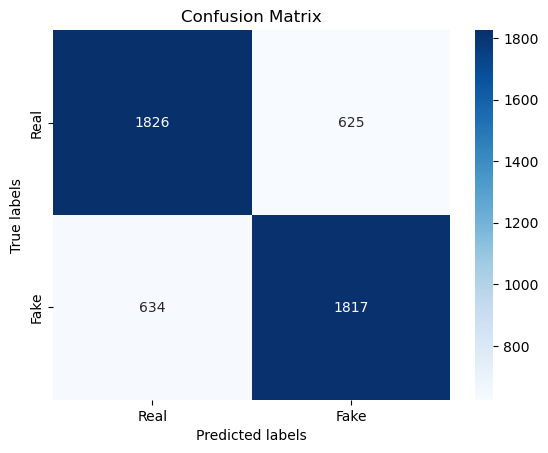

Classification Report:
              precision    recall  f1-score   support

        fake       0.74      0.74      0.74      2451
        real       0.74      0.75      0.74      2451

    accuracy                           0.74      4902
   macro avg       0.74      0.74      0.74      4902
weighted avg       0.74      0.74      0.74      4902

Numero di veri negativi 1826
Numero di veri negativi 625
{'Accuracy': 74.32, 'Precision': 74.41, 'Sensitivity_recall': 74.13, 'Specificity': 74.5002, 'F1_score': 74.27}


In [37]:
# Testing prep
y_true = []
y_pred = []
tempDf = test_df
database = df_enc


# Testing on FAKE images
prediction_fn(tempDf, 'real', y_pred, model, database)

# Testing on REAL images
prediction_fn(tempDf, 'fake', y_pred, model, database)

# Metrics calculation
calculate_metrics(tempDf, y_pred, y_true)


In [38]:
def get_testSet_dirs(test_df):

	real_dirs_list = []
	fake_dirs_list = []

	for index, row in tqdm(test_df.iterrows(), total=test_df.shape[0], desc="Extracting generator directories"):
		
		r_dir = row["real"].split('fourier\\fourier\\')[1].split('+')[0]
		f_dir = row["fake"].split('fourier\\fourier\\')[1].split('+')[0]

		real_dirs_list.append(r_dir)
		fake_dirs_list.append(f_dir)

	real_dirs = sorted(set(real_dirs_list))
	fake_dirs = sorted(set(fake_dirs_list))

	return real_dirs, fake_dirs

In [39]:
def get_testSet_subsets(test_df):

    real_dirs, fake_dirs = get_testSet_dirs(test_df)
    print(real_dirs)
    print(fake_dirs)

    real_subsets = {dir: test_df[test_df['real'].str.startswith("fourier\\fourier\\" + dir + '+')]['real'].tolist() for dir in real_dirs}
    fake_subsets = {dir: test_df[test_df['fake'].str.startswith("fourier\\fourier\\" + dir + '+')]['fake'].tolist() for dir in fake_dirs}

    real_subsets_df = {dir: pd.DataFrame(subset, columns=['real']) for dir, subset in real_subsets.items()}
    fake_subsets_df = {dir: pd.DataFrame(subset, columns=['fake']) for dir, subset in fake_subsets.items()}

    return real_subsets_df, fake_subsets_df

Extracting generator directories:   0%|          | 0/2451 [00:00<?, ?it/s]

['coco', 'imagenet', 'lsun']
['big_gan', 'latent_diffusion', 'taming_transformer']


  0%|          | 0/817 [00:00<?, ?it/s]




Metrics summary for big_gan:


  0%|          | 0/817 [00:00<?, ?it/s]

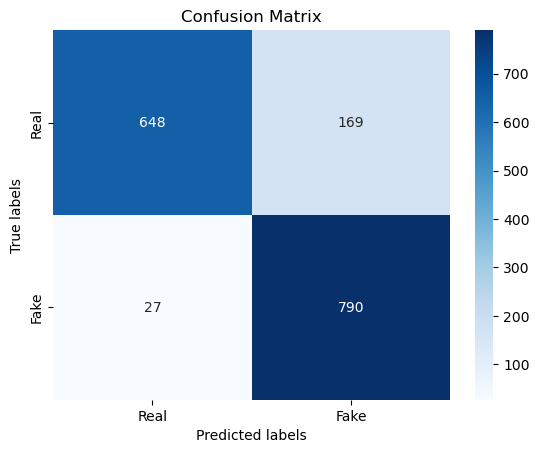

Classification Report:
              precision    recall  f1-score   support

        fake       0.82      0.97      0.89       817
        real       0.96      0.79      0.87       817

    accuracy                           0.88      1634
   macro avg       0.89      0.88      0.88      1634
weighted avg       0.89      0.88      0.88      1634

Numero di veri negativi 648
Numero di veri negativi 169
{'Accuracy': 88.0, 'Precision': 82.38, 'Sensitivity_recall': 96.7, 'Specificity': 79.3146, 'F1_score': 88.97}



Metrics summary for latent_diffusion:


  0%|          | 0/817 [00:00<?, ?it/s]

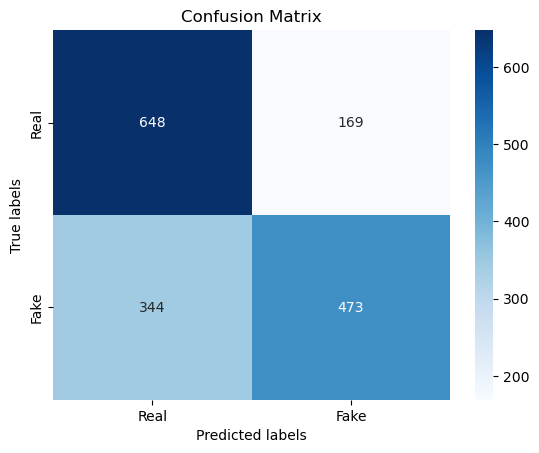

Classification Report:
              precision    recall  f1-score   support

        fake       0.74      0.58      0.65       817
        real       0.65      0.79      0.72       817

    accuracy                           0.69      1634
   macro avg       0.69      0.69      0.68      1634
weighted avg       0.69      0.69      0.68      1634

Numero di veri negativi 648
Numero di veri negativi 169
{'Accuracy': 68.60000000000001, 'Precision': 73.68, 'Sensitivity_recall': 57.89, 'Specificity': 79.3146, 'F1_score': 64.84}



Metrics summary for taming_transformer:


  0%|          | 0/817 [00:00<?, ?it/s]

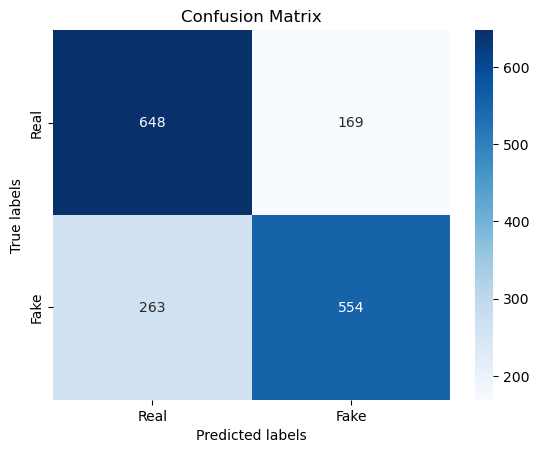

Classification Report:
              precision    recall  f1-score   support

        fake       0.77      0.68      0.72       817
        real       0.71      0.79      0.75       817

    accuracy                           0.74      1634
   macro avg       0.74      0.74      0.73      1634
weighted avg       0.74      0.74      0.73      1634

Numero di veri negativi 648
Numero di veri negativi 169
{'Accuracy': 73.56, 'Precision': 76.63, 'Sensitivity_recall': 67.81, 'Specificity': 79.3146, 'F1_score': 71.95}


In [40]:
# HERE ARE CALCULATED INDIVIDUAL METRICS FOR EACH FAKE GENERATOR
real_subsets, fake_subsets = get_testSet_subsets(test_df)

# Lenght matching 
first_real_key = next(iter(real_subsets))
first_fake_key = next(iter(fake_subsets))

real_df = real_subsets[first_real_key]
first_fake_df = fake_subsets[first_fake_key] 

real_df = real_df.head(len(first_fake_df))

# Testing prep
y_pred_real = [] #Avoid redoing predictions on the same real images subset
y_pred = []
database = df_enc

# Testing on REAL images
prediction_fn(real_df, 'real', y_pred_real, model, database)

for dir, df in fake_subsets.items():
    print(f"\n\n\nMetrics summary for {dir}:")
    
    y_true = []
    y_pred = y_pred_real.copy()

    # Testing on FAKE images
    prediction_fn(df, 'fake', y_pred, model, database)
    # Metrics calculation
    # (the df in input makes no differences)
    calculate_metrics(df, y_pred, y_true)